## ANALYSE EXPLORATOIRE DES DONNEES

### Contexte

### Objectif

### Données et Méthodes

#### 1. Données

Les données que nous allons utiliser se trouve dans le fichier de format SEG-Y (.sgy), un standard dans l'industrie sismique pour stocker des données sismiques de réflexion. Ce format est principalement utilisé en géophysique pour l'explotation pétrolière, gazière et les études géologiques.

Généralement, un fichier .sgy contient les informations suivantes :

1. Un en-tête de fichier
2. En-tête de trace
3. Les données sismiques
4. Les informations supplémentaires

Les codes ci-après, permet d'extraire ces informations du fichier :

In [1]:
# Import des librairies
import os
import segyio                           # pour la manipulation des fichiers .sgy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import hilbert

In [7]:
print(f"Répertoire courant : {os.getcwd()}")

Répertoire courant : /Users/patrickilunga/seam_project/notebooks


In [9]:
os.chdir("/Users/patrickilunga/seam_project")

In [11]:
print(f"Chemin utilisé : {filename}")

Chemin utilisé : data/raw/SEAM_Interpretation_Challenge_1_2DSparseGathers_Depth.sgy


In [13]:
# adresse du fichier
filename = "data/raw/SEAM_Interpretation_Challenge_1_2DSparseGathers_Depth.sgy"

# variables pour stocker les parties principales du fichier
textual_header = None
binary_header = None
trace_headers = []
trace_data = []

# Chargement du fichier
with segyio.open(filename, ignore_geometry=True) as f :
    textual_header = f.text[0].decode('ascii', errors='ignore')  # récupère textual header (3200 octets ASCII)
    binary_header = f.bin                                        # récupère binary
    trace_headers = [header for header in f.header]              # récupère les headers de toutes les traces
    trace_data = f.trace.raw[:]                                  # récupère les données sismiques de toutes les traces
    samples = f.samples                                          # récupère le temps (en µs ou ms) de preleveent de chaque échantillon


L'en-tête de fichier

L'en-tête du fichierm stocké dans la variable textual_header est un ensemble de texte qui décrive généralement :
- l'identification du fichier (Nom, Société, Projet, etc),
- le nombre de traces sismiques,
- le format des données (IBM floating-point, IEEE, etc),
- l'intervalle d'échantillonnage (en $\mu s$ ou $ms$),
- la longueur des traces
- le système des coordonnées utilisées (UTM, WGS84, ect),
- les informations sur l'acquisition des données (source, type des capteurs, etc).

La sortie du code suivant nous donne le contenu global pour notre fichier d'exemple.

In [17]:
# découpage en ligne pour permettre l'affichage propre
lines = [textual_header[i:i+80] for i in range(0, 3200, 80)] 

# affichage
for l in lines :
    print(l)

C 1  Client: SEAM Corp.     Vendor: AGT                     Date: 14 Oct 2014   
C 2  Project Description: SEAM Phase I Interpretation Challenge                 
C 3  SEGY Data Format: IBM Real                            XY Units: Meters     
C 4  Data Description: 2793 Full Azimuth Shot Records with Free Surface         
C 5  Data Type: RTM Migration with Perturbed Vp and Noise in depth   Units: m   
C 6             Sparse collection of 2D offset gathers in depth                 
C 7                                                                             
C 8  Projection: UTM Zone 16                Spheroid: WGS84                     
C 9  Geodetic Datum: WGS84                  Central Meridian: 87 degrees W      
C10  Grid Origin XY: 401,674.66E 3,097,605.23N   Scale Factor: .9996            
C11  Grid Origin Lat Long: 28:00:00N  88:00:00W                                 
C12                                                                             
C13  Corner     X        Y  

Nous pouvons sauvegarder le Textual Header dans un fichier .txt pour une utilisation future.

In [20]:
# Sauvegarder dans un fichier texte
output_file = "results/textual_header.txt"

with open(output_file, 'w') as f:
    for line in lines:
        f.write(line + '\n')

#### Binary header

Le Binary Header contient les informations binaires importantes sur l'ensemble du fichier SEG-Y, notamment :
- Le nombre d'échantillons par trace
- L'intervalle d'échantillonnage
- Le format des données
- L'information sur la géométrie

L'affichage ci-dessous nous permet de visualiser l'ensemble du contenu :

In [24]:
# Affichage formaté des champs principaux
print("BINARY HEADER (informations globales du fichier) :\n")
for field in dir(segyio.BinField):
    if not field.startswith('__'):
        try:
            key = getattr(segyio.BinField, field)
            value = binary_header[key]
            print(f"{field:25} : {value}")
        except:
            pass

BINARY HEADER (informations globales du fichier) :

AmplitudeRecovery         : 0
AuxTraces                 : 0
BinaryGainRecovery        : 0
CorrelatedTraces          : 0
EnsembleFold              : 0
ExtAuxTraces              : 0
ExtEnsembleFold           : 0
ExtSamples                : 0
ExtSamplesOriginal        : 0
ExtTraces                 : 0
ExtendedHeaders           : 0
Format                    : 1
ImpulseSignalPolarity     : 0
Interval                  : 20000
IntervalOriginal          : 20000
JobID                     : 0
LineNumber                : 0
MeasurementSystem         : 1
ReelNumber                : 0
SEGYRevision              : 0
SEGYRevisionMinor         : 0
Samples                   : 751
SamplesOriginal           : 0
SortingCode               : 1
Sweep                     : 0
SweepChannel              : 0
SweepFrequencyEnd         : 0
SweepFrequencyStart       : 0
SweepLength               : 0
SweepTaperEnd             : 0
SweepTaperStart           : 0
Taper   

Par exemple, il suffit de taper le code suivant pour extraire ll'intervalle d'échantillonnage ($\mu s$)

In [125]:
int_samples = binary_header[segyio.BinField.Interval]  # Valeur en microsecondes
int_samples = int_samples/1000                           # Conversion en millisecondes
print(f"Intervalle d'échantillonnage : {int_samples} ms")

Intervalle d'échantillonnage : 20.0 ms


Pareil pour le nombre d'échantillon par trace :

In [127]:
n_samples = binary_header[segyio.BinField.Samples]
print(f"Nombre d'échantillons par trace : {n_samples}")

Nombre d'échantillons par trace : 751


#### Trace headers

C'est une liste qui contient un header par trace. On y trouve les éléments comme :
. sx, sy : les coordonnées source (x, y)
. gx, gy : les coordonnées géophone (x, y)
. offset : distance source-recepteur, ect

Pour cet exemple, le trace_headers ...


In [28]:
# On affiche les 5 premiers
for i, header in enumerate(trace_headers[:5]):  
    print(f"--- Trace {i} ---")
    print(f"Source X       : {header[segyio.su.sx]}")
    print(f"Geophone X     : {header[segyio.su.gx]}")
    print(f"Offset         : {header[segyio.su.offset]}")
    print(f"Numéro de shot : {header[segyio.su.fldr]}")
    print(f"Trace dans shot: {header[segyio.su.tracr]}")
    print()

--- Trace 0 ---
Source X       : 31740
Geophone X     : 31740
Offset         : 11600
Numéro de shot : 0
Trace dans shot: 0

--- Trace 1 ---
Source X       : 31740
Geophone X     : 31740
Offset         : 11600
Numéro de shot : 0
Trace dans shot: 0

--- Trace 2 ---
Source X       : 31740
Geophone X     : 31740
Offset         : 11600
Numéro de shot : 0
Trace dans shot: 0

--- Trace 3 ---
Source X       : 31740
Geophone X     : 31740
Offset         : 11600
Numéro de shot : 0
Trace dans shot: 0

--- Trace 4 ---
Source X       : 31740
Geophone X     : 31740
Offset         : 11600
Numéro de shot : 0
Trace dans shot: 0



#### Echelle temporelle

L'objet samples contient les temps (ou profondeurs temporelles) correspondant à chaque échantillon d’une trace. C’est l’échelle temporelle en millisecondes (ms)  ou microsecondes (µs), par exemple :

In [148]:
samples[:10]

array([  0.,  20.,  40.,  60.,  80., 100., 120., 140., 160., 180.])

Cet objet donne la position temporelle de chaque échantillon, utile pour afficher les traces en fonction du temps  plutôt qu’en indice brut

#### Données Sismiques - Traces

L'objet trace_data est un tableau de dimension (n_traces, n_samples) qui contient toutes les données sismiques (ou traces). Ce sont des series temporelles des amplitudes du signal sismique. En ligne on trouve les traces et en colonne les echantillons :
- n_traces : nombre total de traces 
- n_samples : nombre d'échantillon par trace

Chaque échantillon représente une mesure de l'onde sismique à un temps donné.

Structure des données 

In [32]:
print(f"Type des données : {type(trace_data)}")
print(f"Dimensions : {trace_data.shape}")
print(f"\t Nombre de traces : {trace_data.shape[0]}")
print(f"\t Nombre d'échantillons : {trace_data.shape[1]}")
print(f"Type d'un échantillon : {trace_data.dtype}")

Type des données : <class 'numpy.ndarray'>
Dimensions : (990, 751)
	 Nombre de traces : 990
	 Nombre d'échantillons : 751
Type d'un échantillon : float32


Ainsi, si nous voulons connaitre les 10 premiers échantiollon de la prémière trace, nous pouvons taper le code suivant :

In [35]:
print(trace_data[0, :10])

[ 405.2705    463.29712   347.06323    32.827682 -259.48657  -325.9668
 -206.44856  -102.21112   -34.064743   15.99901 ]


Visualisation d'une trace

En pratique, une trace ressemble à une courbe sismique : sur l'axe $x$ le temps et sur l'axe $y$ l'amplitude (force du signal réflechi). Elle sert à imager le sous-sol en analysant les réflexions des ondes sismiques, identifier des structures gêologiques (failles, réservoirs, couches sédimentaires) et déterminer les zones d'interêt pour l'exploitation pétrole ou gazière.

Visualisation d'une trace

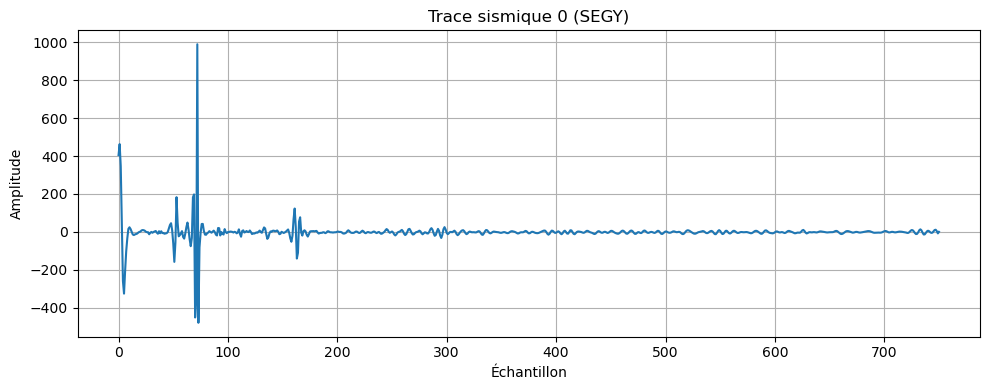

In [40]:
# Visualisation d'une trace

plt.figure(figsize=(10, 4))
plt.plot(trace_data[0, ])
plt.title("Trace sismique 0 (SEGY)")
plt.xlabel("Échantillon")
plt.ylabel("Amplitude")
plt.grid(True)
plt.tight_layout()
plt.show()

Explication de la sortie : 

- ...

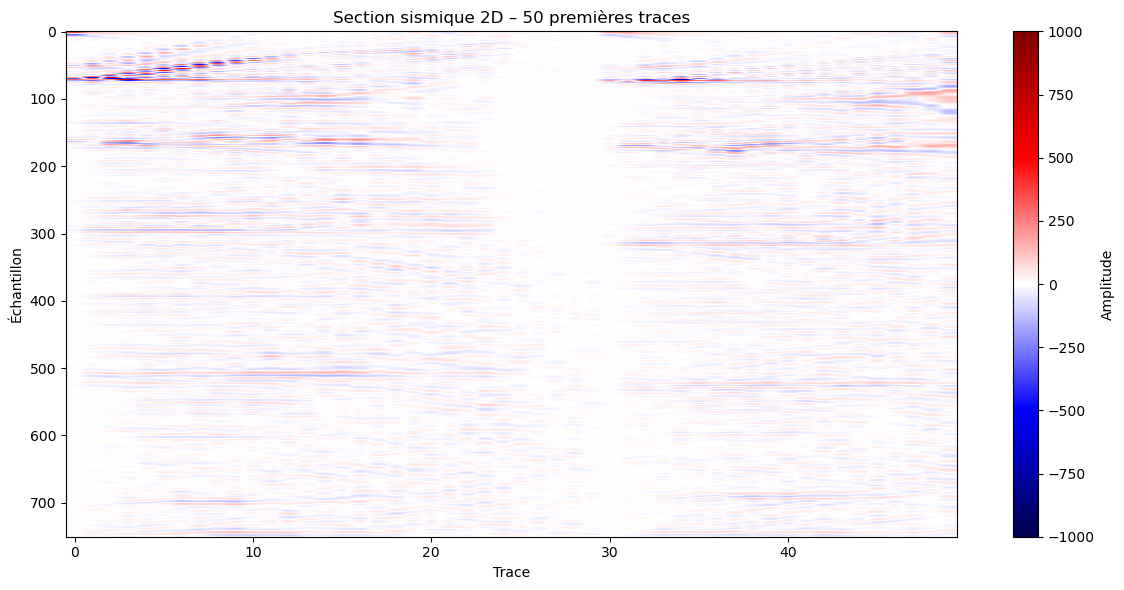

In [43]:
# Visualisation de la section sismique 2D
subset = trace_data[:50, :] 

plt.figure(figsize=(12, 6))
plt.imshow(subset.T, cmap="seismic", aspect="auto", vmin=-1e3, vmax=1e3)
plt.colorbar(label="Amplitude")
plt.title("Section sismique 2D – 50 premières traces")
plt.xlabel("Trace")
plt.ylabel("Échantillon")
plt.tight_layout()
#plt.savefig(os.path.join(ROOT_DIR, "results", "seismic_section_2d.png"), dpi=150)
plt.show() 

Il est important d'analyser les traces avec les informations contenu dans trace_header ... Nous allons donc fusionner trace_data et trace_headers dans un même dataframe pour faciliter l'analyse. Ceci va nous permettre par exemple de :
- filtrer les traces selon leur offset, shot, etc,
- faire une analyse statistique sur les amplitudes
- préporer les données pour un apprentissage automatique. 

Extraction des champs d'interets dans trace_headers

In [47]:
headers_list = []

for i, header in enumerate(trace_headers):
    headers_list.append({
        'trace_index': i,
        'fldr': header[segyio.su.fldr],         # Numéro de shot
        'tracr': header[segyio.su.tracr],       # Numéro de trace dans le shot
        'offset': header[segyio.su.offset],     # Offset (distance source-récepteur)
        'sx': header[segyio.su.sx],             # Coordonnée X source
        'sy': header[segyio.su.sy],             # Coordonnée Y source
        'gx': header[segyio.su.gx],             # Coordonnée X géophone
        'gy': header[segyio.su.gy],             # Coordonnée Y géophone
        'tracl': header[segyio.su.tracl]        # Numéro de trace dans le levé
    })

# Créer un DataFrame pour les headers
df_headers = pd.DataFrame(headers_list)

# Sauvegarde en CSV pour un usage futur
df_headers.to_csv("results/trace_headers.csv", index=False)

Création d'un dataframe pour les amplitudes sismiques

In [50]:
# Chaque colonne = échantillon, chaque ligne = trace
columns = [f"sample_{i}" for i in range(trace_data.shape[1])]

# Création du dataframe
df_traces = pd.DataFrame(trace_data, columns=columns)

# Sauvegarde en CSV pour un usage futur
df_traces.to_csv("results/trace_data.csv", index=False)

Fusion des df_headers et df_traces

In [53]:
# Concaténer headers + données sismiques
df_full = pd.concat([df_headers, df_traces], axis = 1)

# Sauvegarde
df_full.to_csv("results/df_full.csv", index=False)

In [55]:
df_full.shape

(990, 760)

## Analyse Univariée

#### 1.1. Statistiques isuelles des amplitudes

In [58]:
df_full.head(10)

,trace_index,fldr,tracr,offset,sx,sy,gx,gy,tracl,sample_0,...,sample_741,sample_742,sample_743,sample_744,sample_745,sample_746,sample_747,sample_748,sample_749,sample_750
0,0,0,0,11600,31740,24000,31740,24000,0,405.270508,...,3.466121,-1.995775,-5.403693,-4.182439,2.442975,9.784937,11.240048,4.034663,-7.978045,0.118023
1,1,0,0,11600,31740,24000,31740,24000,0,95.859558,...,35.310822,25.341583,-8.684219,-34.841919,-25.082352,11.343506,38.070694,29.036362,-7.364447,0.245027
2,2,0,0,11600,31740,24000,31740,24000,0,58.497421,...,40.700333,22.380600,-11.433210,-28.166321,-9.407252,28.437469,46.464096,24.178848,-24.026871,0.435502
3,3,0,0,11600,31740,24000,31740,24000,0,27.423660,...,5.142024,-16.984711,-17.547073,8.214530,39.841782,51.384247,35.832047,4.632138,-28.843292,0.390546
4,4,0,0,11600,31740,24000,31740,24000,0,15.300794,...,-15.485108,-46.530075,-48.247330,-14.086219,34.167038,58.848877,47.268402,15.570268,-14.099780,0.225315
5,5,0,0,11600,31740,24000,31740,24000,0,10.109764,...,-34.847198,-32.066559,-14.759103,17.228531,46.441467,52.560379,34.113846,3.805709,-17.340179,0.214450
6,6,0,0,11600,31740,24000,31740,24000,0,-5.200202,...,-61.407303,-54.609802,-3.717512,57.380203,84.543289,59.763641,12.696247,-19.601562,-26.786896,0.230168
7,7,0,0,11600,31740,24000,31740,24000,0,12.499658,...,-59.739502,2.689641,68.417862,94.750168,63.334976,3.963862,-35.516037,-29.546753,0.291656,-0.087766
8,8,0,0,11600,31740,24000,31740,24000,0,7.957801,...,12.634245,71.414902,113.517700,110.887482,48.302902,-41.529694,-94.718735,-80.695435,-24.835464,-0.004091
9,9,0,0,11600,31740,24000,31740,24000,0,3.696818,...,13.103761,89.109283,148.467941,150.167740,72.796814,-41.501083,-115.457657,-111.178909,-59.105255,0.305417


In [60]:
# séléction des colonnes amplitudes
sample_columns = [col for col in df_full.columns if col.startswith("sample_") ]
df_amplitude = df_full[sample_columns].values

# stattistiques globales
mean_amp = np.mean(df_amplitude)
sd_amp = np.std(df_amplitude)
min_amp = np.min(df_amplitude)
max_amp = np.max(df_amplitude)

print("Les statistiques globales sur les amplitudes :\n")
print(f" - Moyenne : {mean_amp:.6f}")
print(f" - Ecart-type : {sd_amp:.6f}")
print(f" - Minimum : {min_amp:.6f}")
print(f" - Maximum : {max_amp:.6f}")

Les statistiques globales sur les amplitudes :

 - Moyenne : 1.941444
 - Ecart-type : 58.318661
 - Minimum : -3526.467041
 - Maximum : 4517.863281


Historgramme de frenquence

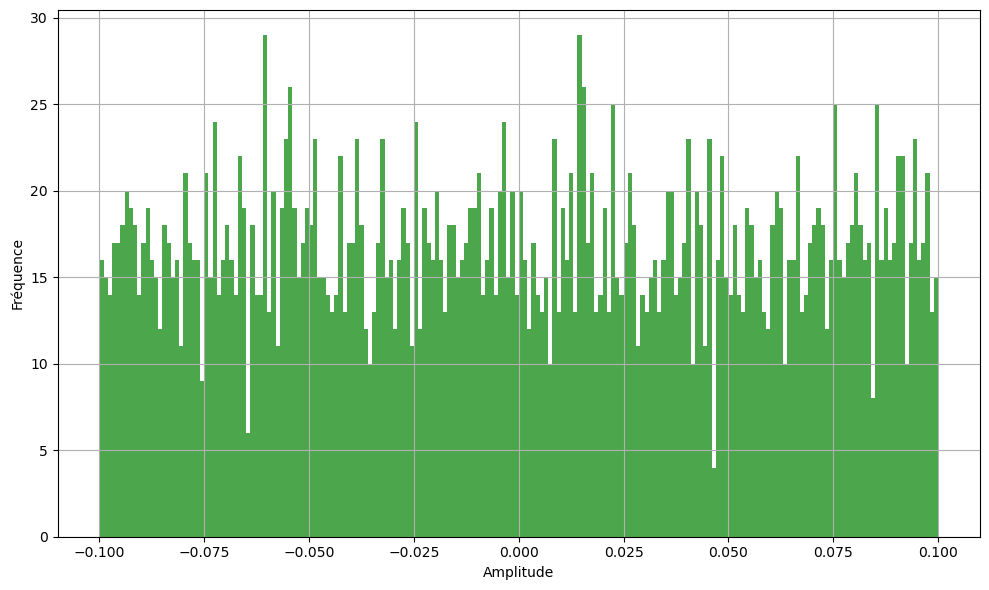

In [63]:
# Aplatir toutes les valeurs dans une seule liste
all_amplitudes = df_amplitude.ravel()

# Histogramme
plt.figure(figsize=(10, 6))
plt.hist(all_amplitudes, bins=200, color='green', alpha=0.7, range=(-0.1, 0.1))
#plt.title(f"Histogramme des amplitudes")
plt.xlabel("Amplitude")
plt.ylabel("Fréquence")
plt.grid(True)
plt.tight_layout()
plt.savefig(f"results/histogram_amp.png")
plt.show()

#### 1.2. les statistiques remarquables

#### a. Calcul de RMS

Le RMS (Root Mean Square) est un attribut sismique qui mesure l'energie d'un signal. Il est défini par la formule :
$$RMS = \sqrt{\frac{1}{N} \sum_{i=1}^{N} x_{i}^2}$$
où :
- $x_i$ : amplitude à chauqe échantillon
- $N$ : le nombre total d'échantillon dans la trace.

Le RMS est très utilisé en géophysique, car il permet :
- la détection de réservoirs - les zones à forte énergie (haut amplitude RMS) peuvent indiquer des réservoirs
- le suivi de continuité - aide à identifier les discontinuités comme les failles
- l'analyse AVO/AVA - mesure de l'energie en fonction de l'offset (Amplitude varie selon l'offset source-récepteur et Amplitude varie selon l'angle d'incidence)

In [169]:
# Calculer l'amplitude RMS pour chaque trace
df_full['rms'] = np.sqrt(np.mean(df_amplitude**2, axis=1))

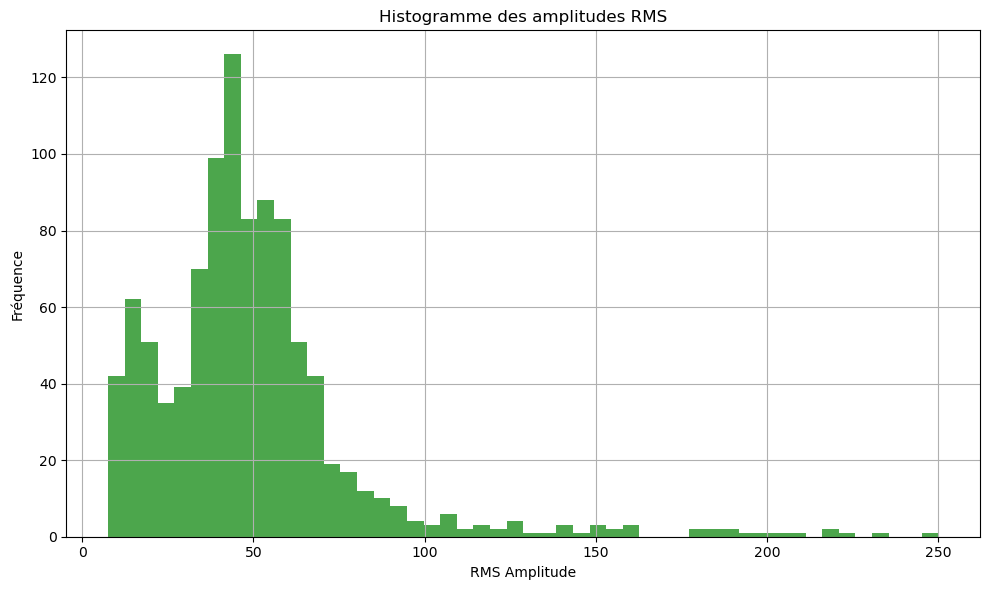

In [171]:
# Histogramme des valeurs RMS
plt.figure(figsize=(10, 6))
plt.hist(df_full['rms'], bins=50, color='green', alpha=0.7)
plt.title("Histogramme des amplitudes RMS")
plt.xlabel("RMS Amplitude")
plt.ylabel("Fréquence")
plt.grid(True)
plt.tight_layout()
plt.savefig("results/histogram_rms.png")
plt.show()

#### b. Enveloppe d'amplitude (Hilbert Transform)

Ce paramètre montre les réflecteurs dominants et permet de détecter les changements stratigraphiques.

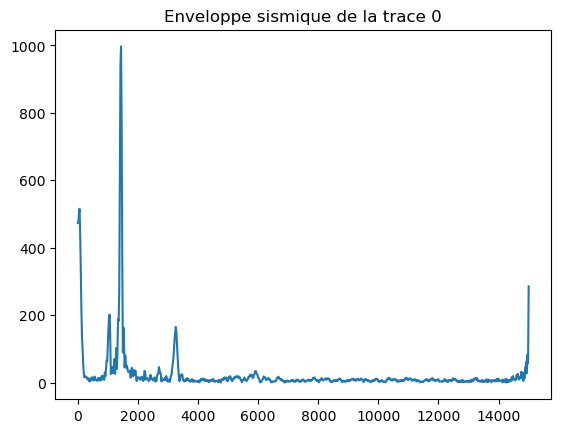

In [151]:
# Exemple avec la première trace
trace_0 = df_full[sample_columns].iloc[0]
envelope_0 = np.abs(hilbert(trace_0))

plt.plot(samples, envelope_0)
plt.title("Enveloppe sismique de la trace 0")
plt.show()

In [95]:
# Calcul pour toutes les traces :
envelope_max = np.max(np.abs(np.array([np.abs(hilbert(trace)) for trace in df_amplitude])), axis=1)

#### c. Fréquence instatanée

Ce parametre indique les variations de fréquences le long de la trace et permet de comprendre le changement lithologique.

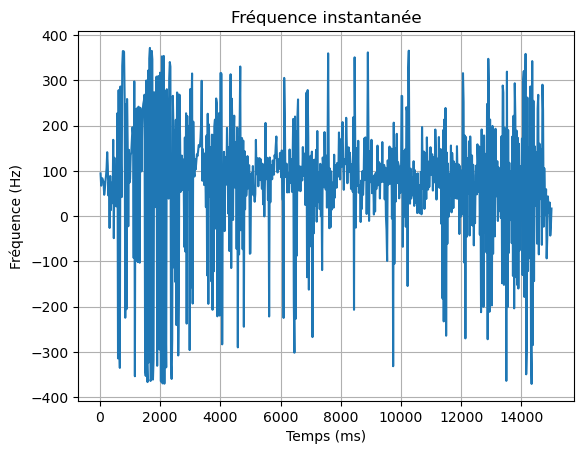

In [155]:
analytic_signal = hilbert(trace)
instantaneous_phase = np.unwrap(np.angle(analytic_signal))
instantaneous_frequency = np.diff(instantaneous_phase) / (2.0 * np.pi) * n_samples

# affichage
plt.plot(samples[1:], instantaneous_frequency)
plt.title("Fréquence instantanée")
plt.xlabel("Temps (ms)")
plt.ylabel("Fréquence (Hz)")
plt.grid(True)
plt.show()

#### d. Phase instatanée

Très utile pour l’interprétation en AVO et en inversion

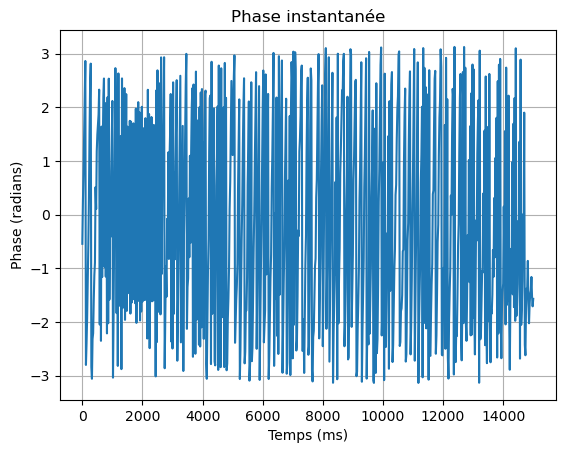

In [157]:
instantaneous_phase = np.angle(analytic_signal)

plt.plot(samples, instantaneous_phase)
plt.title("Phase instantanée")
plt.xlabel("Temps (ms)")
plt.ylabel("Phase (radians)")
plt.grid(True)
plt.show()

#### e. Puissance instantanée (Amplitude²) 

Ce paramètre montre l’énergie locale du signal

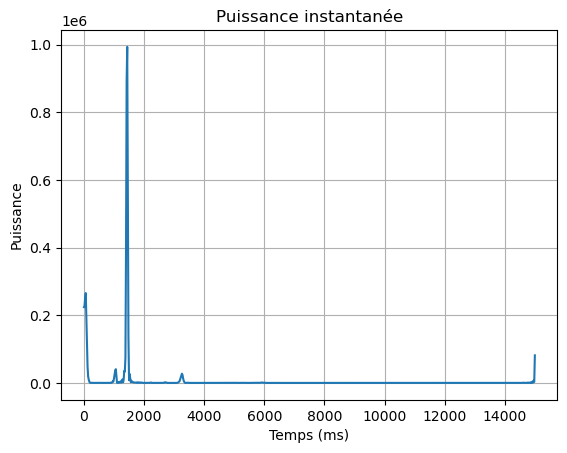

In [159]:
power_0 = envelope_0 ** 2

plt.plot(samples, power_0)
plt.title("Puissance instantanée")
plt.xlabel("Temps (ms)")
plt.ylabel("Puissance")
plt.grid(True)
plt.show()

#### f. Z-Crossing (zéros-crossings)

Paramètre important pour la lecture de la continuité des réflecteurs

In [163]:
zero_crossings = np.where(np.diff(np.sign(trace)))[0]
print(f"Nombre de zéros-crossings : {len(zero_crossings)}")

Nombre de zéros-crossings : 188


Pour l'ensemble des parametres calculés, nous pouvons les ajouter dans le df_full

In [174]:
# Calcul et ajout dans le df_full
df_full['envelope_max'] = np.max(np.abs(np.array([np.abs(hilbert(trace)) for trace in df_amplitude])), axis=1)
df_full['mean_abs'] = np.mean(np.abs(df_amplitude), axis=1)
df_full['max_amp'] = np.max(np.abs(df_amplitude), axis=1)